# TRANSFER LEARNING
*How to deploy accurate deep learning models in a timesaving way.*


## DESCRIPTION
According to Andrew Ng, co-founder of Google Brain, transfer learning will be - after supervised learning - the next driver of machine learning commercial success. 

When developing deep learning models for business applications (computer vision, speech recognition, etc) three obstacles usually occur : 
* Data availability : getting vast amounts of labeled data is hard. Most deep learning models which solve complex problems, need a whole lot of data. Getting vast amounts of labeled data for supervised models can be really difficult, considering the time and effort it takes to label data points.
* Performance : Efficient deep learning models don't generalize well at all. Most deep learning models are very specialized to a particular domain or even a specific task. While these might be state-of-the-art models, with really high accuracy and beating all benchmarks, it would be only on very specific datasets and end up suffering loss in performance when used in a new task which might still be similar to the one it was trained on.
* Costs : even with data and efficient models, training is computationally intensive. The most complex models take weeks to train using hundreds of machines equipped with expensive GPUs.

Transfer learning allows us to build accurate models in a timesaving way. Instead of starting the learning process from scratch, you start from patterns that have been learned when solving a different problem. This master class will show you how. 


In this notebook we will classify pictures of dogs and cats from the Kaggle competition dataset [Dogs vs. Cats"](https://www.kaggle.com/c/dogs-vs-cats), using the VGG-16 model pre-trained on the imagenet dataset and obtained through Keras library.

We compare the results of three different models, the first one using only VGG-16 for feature extration with the VGG layers frozen during training, the second one is similar to the first one with the addition of data augmentation, and the last model has the block 4 & 5 of the VGG unfrozen and data augmentation during its training.

Finaly we compare the the results of the three models.

## Notebook Layout

0. Data and tensorflow 2.0 setup
1. Import Data and VGG model
2. Transfer as feature extration only
3. Transfer with data augmentation
4. Transfer with partial training
5. Model comparaison

### 0. Data and tensorflow 2.0 setup

In [4]:
! pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 450kB 40.4MB/s 
     |████████████████████████████████| 3.8MB 28.6MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.6.3 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled googl

__/!\ Important /!\__ You may have to restart your runtime. Go in "Runtime" in the Google Collab menu, and click on "Restart Runtime". If everything went well, you should get "2.0.0" when running the cell below.

In [2]:
# Check which tensorflow version you are using
# Version 2.0.0 is necessary to run this notebook
import tensorflow as tf
print(tf.__version__)

2.0.0


In [6]:
# Mount your notebook on your gdrive
# After running the cell follow the instruction and past the key
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import glob
import numpy as np
import os
import shutil
import pandas as pd
np.random.seed(42)
import zipfile

In [0]:
# Download data in a zip file in your gdrive
# Unzip the data and save them on the instance
local_zip = "gdrive/Shared drives/Lab Wewyse/02. Master Class/2019 11 29 - Transfer Learning/02. Workshop/small-dog-cat.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('small-dog-cat')
zip_ref.close()

### 1. Import Data and VGG model

In [0]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

In [27]:
IMG_DIM = (150, 150) #setting image dim

train_files = glob.glob('small-dog-cat/small-dog-cat/training_data/*') #import training data
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files] #change images files into arrays
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[3].split('.')[0].strip() for fn in train_files] #take the 'dog'/'cat' off file name for labels

validation_files = glob.glob('small-dog-cat/small-dog-cat/validation_data/*') #import training data
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files] #change image files into arrays
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[3].split('.')[0].strip() for fn in validation_files] #take the 'dog'/'cat' off file name for labels

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


(150, 150, 3)


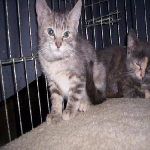

In [28]:
# Changing pixel values from (0,255) to (0,1)
# deep learning works better with small inputs

train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [0]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

In [30]:
# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat'] [1 0 0 1 0 0 0 1 0 0]


In [0]:
# import trained VGG-16 model from keras

from keras.applications import vgg16
from keras.models import Model
import keras


In [32]:

vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)


58892288/58889256 [==============================] - 45s 1us/step


In [0]:
# flattening output results so we can feed it to fully connected layers (our classifier)
output = vgg.layers[-1].output


In [0]:
output = tf.keras.layers.Flatten()(output)

In [0]:
vgg_model = tf.keras.models.Model(vgg.input, output)

In [36]:

# freezing layers of our vgg so weights don't change during training
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

# taking a look at our vgg model layers
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fd21c3f2c18>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd21ba8e080>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd21ba8ea90>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd2103c65c0>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd2103c66a0>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd2103d9e10>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd2103ecf98>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd21037f208>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd210390978>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd21039cc50>,block3_conv3,False


(1, 4, 4, 512)


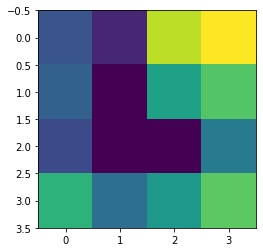

In [37]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

### 2. Transfer learning only for feature extration

In [39]:
# Using our vgg model to extract features out off training data

def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (1000, 8192)


In [40]:
# Creating a simple ANN (our classifier) to which we will feed the features we extrated through our vgg model

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = vgg_model.output_shape[1]

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(input_shape,)))
model.add(tf.keras.layers.Dense(512, activation='relu', input_dim=input_shape))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Training our ANN
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 2s 802us/sample - loss: 0.4230 - accuracy: 0.8033 - val_loss: 0.3163 - val_accuracy: 0.8540
Epoch 2/30
3000/3000 [==============================] - 1s 310us/sample - loss: 0.2934 - accuracy: 0.8690 - val_loss: 0.2522 - val_accuracy: 0.8910
Epoch 3/30
3000/3000 [==============================] - 1s 303us/sample - loss: 0.2418 - accuracy: 0.8997 - val_loss: 0.2755 - val_accuracy: 0.8820
Epoch 4/30
3000/3000 [==============================] - 1s 296us/sample - loss: 0.2128 - accuracy: 0.9103 - val_loss: 0.3133 - val_accuracy: 0.8610
Epoch 5/30
3000/3000 [==============================] - 1s 303us/sample - loss: 0.1633 - accuracy: 0.9330 - val_loss: 0.2577 - val_accuracy: 0.8870
Epoch 6/30
3000/3000 [==============================] - 1s 290us/sample - loss: 0.1372 - accuracy: 0.9443 - val_loss: 0.2829 - val_accuracy: 0.8790
Epoch 7/30
3000/3000 [==============================] - 1s 297us

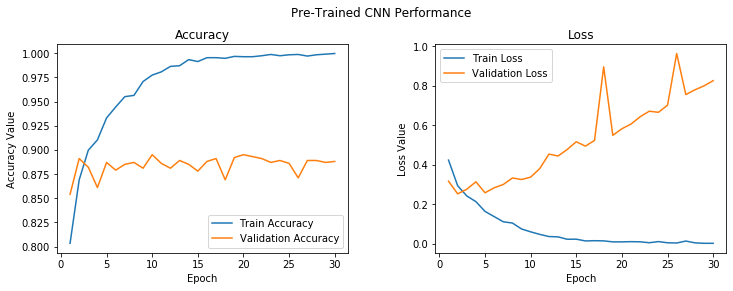

In [42]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-Trained CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('cats_dogs_tlearn_basic_cnn.h5')

### 3. Transfer with data augmentation

In [0]:
# Creating our data generator
# It creates a new variation of each image at each epoch
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


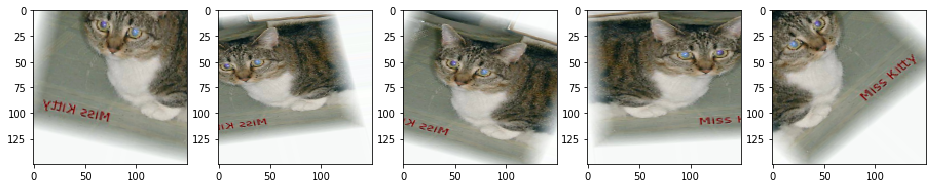

In [47]:
# Visualizing the transformations
img_id = 2595
img_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
rdm_img = [next(img_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in rdm_img])
l = [ax[i].imshow(rdm_img[i][0][0]) for i in range(0,5)]

In [48]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = tf.keras.models.Sequential()
model.add(vgg_model)
model.add(tf.keras.layers.Dense(512, activation='relu', input_dim=input_shape))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
              
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1) 

Epoch 1/30
100/100 [==============================] - 72s 724ms/step - loss: 0.6639 - accuracy: 0.6133 - val_loss: 0.5116 - val_accuracy: 0.8020
Epoch 2/30
100/100 [==============================] - 66s 661ms/step - loss: 0.5645 - accuracy: 0.7143 - val_loss: 0.4266 - val_accuracy: 0.8170
Epoch 3/30
100/100 [==============================] - 66s 660ms/step - loss: 0.5201 - accuracy: 0.7513 - val_loss: 0.3793 - val_accuracy: 0.8380
Epoch 4/30
100/100 [==============================] - 66s 659ms/step - loss: 0.4728 - accuracy: 0.7817 - val_loss: 0.3561 - val_accuracy: 0.8400
Epoch 5/30
100/100 [==============================] - 66s 661ms/step - loss: 0.4605 - accuracy: 0.7750 - val_loss: 0.3309 - val_accuracy: 0.8540
Epoch 6/30
100/100 [==============================] - 66s 660ms/step - loss: 0.4409 - accuracy: 0.7967 - val_loss: 0.3168 - val_accuracy: 0.8630
Epoch 7/30
100/100 [==============================] - 66s 661ms/step - loss: 0.4308 - accuracy: 0.8023 - val_loss: 0.3001 - val_ac

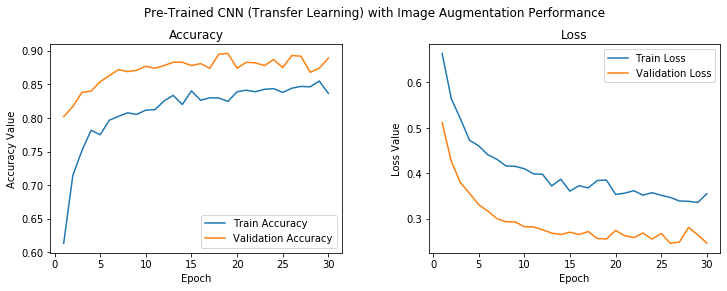

In [49]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-Trained CNN (Transfer Learning) with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('cats_dogs_tlearn_img_aug_cnn.h5')

### 4. Transfer with partial training

In [53]:
# Unfreezing block4 and block5 for training
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fd21c3f2c18>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd21ba8e080>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd21ba8ea90>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd2103c65c0>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd2103c66a0>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd2103d9e10>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd2103ecf98>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd21037f208>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd210390978>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd21039cc50>,block3_conv3,False


In [54]:
#Set data generator
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = tf.keras.models.Sequential()
model.add(vgg_model)
model.add(tf.keras.layers.Dense(512, activation='relu', input_dim=input_shape))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])
              
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)

Epoch 1/30
100/100 [==============================] - 67s 674ms/step - loss: 0.5898 - accuracy: 0.6853 - val_loss: 0.3519 - val_accuracy: 0.8490
Epoch 2/30
100/100 [==============================] - 67s 671ms/step - loss: 0.4262 - accuracy: 0.8100 - val_loss: 0.4473 - val_accuracy: 0.8160
Epoch 3/30
100/100 [==============================] - 67s 671ms/step - loss: 0.3567 - accuracy: 0.8373 - val_loss: 0.1943 - val_accuracy: 0.9140
Epoch 4/30
100/100 [==============================] - 67s 673ms/step - loss: 0.3001 - accuracy: 0.8707 - val_loss: 0.1841 - val_accuracy: 0.9190
Epoch 5/30
100/100 [==============================] - 67s 670ms/step - loss: 0.2870 - accuracy: 0.8760 - val_loss: 0.1578 - val_accuracy: 0.9380
Epoch 6/30
100/100 [==============================] - 67s 670ms/step - loss: 0.2496 - accuracy: 0.8990 - val_loss: 0.2136 - val_accuracy: 0.9080
Epoch 7/30
100/100 [==============================] - 67s 671ms/step - loss: 0.2385 - accuracy: 0.8980 - val_loss: 0.1411 - val_ac

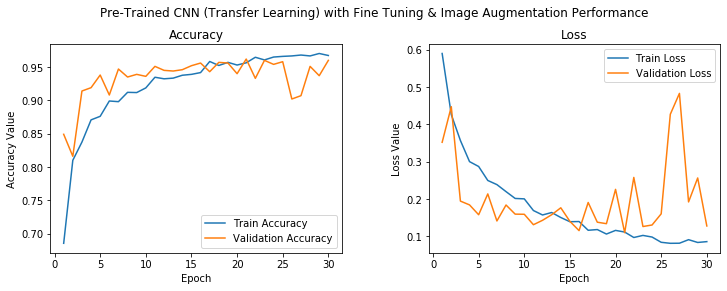

In [56]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-Trained CNN (Transfer Learning) with Fine Tuning & Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

### 5. Results comparaison

In [0]:
# load dependencies
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
import model_evaluation_utils as meu
%matplotlib inline

# load saved models
tl_cnn = tf.keras.models.load_model('cats_dogs_tlearn_basic_cnn.h5')
tl_img_aug_cnn = tf.keras.models.load_model('cats_dogs_tlearn_img_aug_cnn.h5')
tl_img_aug_finetune_cnn = tf.keras.models.load_model('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

# load other configurations
IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
num2class_label_transformer = lambda l: ['cat' if x == 0 else 'dog' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'cat' else 1 for x in l]

# load VGG model for bottleneck features
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', 
                  input_shape=input_shape)
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
vgg_model = tf.keras.models.Model(vgg.input, output)
vgg_model.trainable = False

def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [61]:
IMG_DIM = (150, 150)

test_files = glob.glob('small-dog-cat/small-dog-cat/test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[3].split('.')[0].strip() for fn in test_files]

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255
test_labels_enc = class2num_label_transformer(test_labels)

print('Test dataset shape:', test_imgs.shape)
print(test_labels[0:5], test_labels_enc[0:5])

Test dataset shape: (1000, 150, 150, 3)
['dog', 'cat', 'cat', 'cat', 'dog'] [1, 0, 0, 0, 1]


In [62]:
test_bottleneck_features = get_bottleneck_features(vgg_model, test_imgs_scaled)

predictions = tl_cnn.predict_classes(test_bottleneck_features, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.893
Precision: 0.893
Recall: 0.893
F1 Score: 0.893

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.90      0.89      0.89       500
         dog       0.89      0.90      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   cat  dog
Actual: cat  444        56 
        dog  51         449


/content/model_evaluation_utils.py:61: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
/content/model_evaluation_utils.py:63: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


In [63]:
predictions = tl_img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.903
Precision: 0.904
Recall: 0.903
F1 Score: 0.9029

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.92      0.88      0.90       500
         dog       0.88      0.93      0.91       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   cat  dog
Actual: cat  439        61 
        dog  36         464


/content/model_evaluation_utils.py:61: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
/content/model_evaluation_utils.py:63: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


In [64]:
predictions = tl_img_aug_finetune_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.952
Precision: 0.9529
Recall: 0.952
F1 Score: 0.952

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.97      0.93      0.95       500
         dog       0.93      0.97      0.95       500

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   cat  dog
Actual: cat  465        35 
        dog  13         487


/content/model_evaluation_utils.py:61: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
/content/model_evaluation_utils.py:63: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


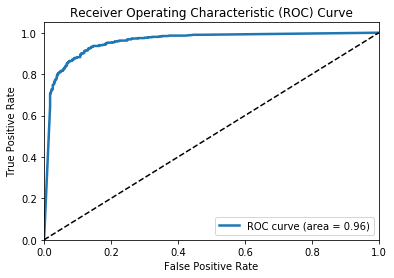

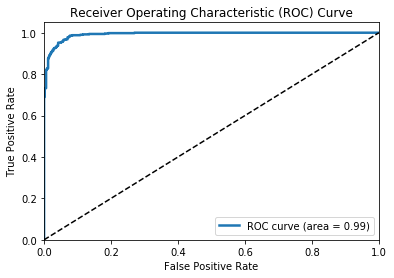

In [65]:
# worst model - Pre-trained CNN model as a Feature Extractor
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
test_features_vgg = get_bottleneck_features(vgg_model, test_imgs_scaled)


meu.plot_model_roc_curve(tl_cnn, test_features_vgg, 
                         true_labels=test_labels_enc, 
                         class_names=[0, 1]) 

# best model - transfer learning with fine-tuning & image augmentation 
meu.plot_model_roc_curve(tl_img_aug_finetune_cnn, test_imgs_scaled, 
                         true_labels=test_labels_enc, 
                         class_names=[0, 1])